# New York Green Cab 2015/09 data

### data source: http://www.nyc.gov/html/tlc/html/about/trip_record_data.shtml

In [2]:
import pickle
import pandas as pd
import numpy as np
import datetime as dt
import matplotlib.pyplot as plt
import matplotlib
from dateutil import parser
from sklearn.metrics import r2_score
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import ParameterGrid
from sklearn import cross_validation
from sklearn.grid_search import GridSearchCV 
from sklearn.ensemble import RandomForestRegressor
from sklearn.cluster import KMeans
%matplotlib inline

print('done')

done


In [3]:
# load data, check the dataframe info and shape

df = pd.read_csv('../data/green_tripdata_2015-09.csv')
print('The shape of the dataframe is', np.shape(df))

The shape of the dataframe is (1494926, 21)


In [4]:
# extract time details from the original dataset

df['lpep_pickup_day'] = df.lpep_pickup_datetime.apply(lambda x: parser.parse(x).day)
df['lpep_pickup_hour'] = df.lpep_pickup_datetime.apply(lambda x: parser.parse(x).hour)
df['lpep_pickup_min'] = df.lpep_pickup_datetime.apply(lambda x: parser.parse(x).minute)
df['lpep_pickup_sec'] = df.lpep_pickup_datetime.apply(lambda x: parser.parse(x).second)

df['lpep_dropoff_day'] = df.Lpep_dropoff_datetime.apply(lambda x: parser.parse(x).day)
df['lpep_dropoff_hour'] = df.Lpep_dropoff_datetime.apply(lambda x: parser.parse(x).hour)
df['lpep_dropoff_min'] = df.Lpep_dropoff_datetime.apply(lambda x: parser.parse(x).minute)
df['lpep_dropoff_sec'] = df.Lpep_dropoff_datetime.apply(lambda x: parser.parse(x).second)

df['weekend_holiday_flag'] = df.lpep_pickup_day.apply(lambda x: x in [4,5,6,12,13,19,20,26,27])

# save cleaned csv file
df.to_csv('../data/green_cleaned.csv',index=False)

In [3]:
# load the data
df = pd.read_csv('../data/green_cleaned.csv')

**Summary:**
* The original dataset has 1494926 rows and 21 columns.
* I parsed the two columns: lpep_pickup_datetime and Lpep_dropoff_datetime to extract the days and time of all pick-ups and drop-offs, as well as the weekend_flag (9 new columns add in the cleaned dataset).

603.1
0.0
0


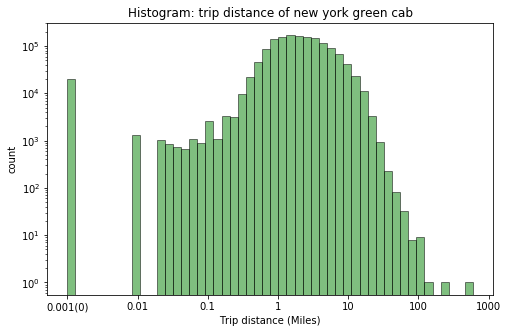

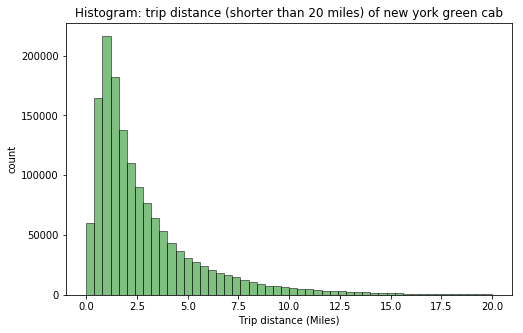

In [4]:
# histogram plot of Trip_distance

# if all data points are included
print(np.max(df.Trip_distance))
print(np.min(df.Trip_distance))
print(len(df[df.Trip_distance == 0.001]))

trip_distance = np.array(df.Trip_distance)
# set trip_distance = 0 as 0.001 so it could be shown in log scale, even with couple outliers
trip_distance[trip_distance == 0] = 0.001

n_bins = 50
# there are couple trips have very long trip distance
# take log10 on both trip distance and the counts to clearly show the trend
plt.figure(figsize = (8,5))
n, bins, patches = plt.hist(np.log10(trip_distance), n_bins, alpha = 0.5, 
                           edgecolor='k', color='green', log=True)
#print(n)
plt.xlabel('Trip distance (Miles)')
plt.ylabel('count')
plt.xticks([-3,-2,-1,0,1,2,3],['0.001(0)','0.01','0.1','1','10','100','1000'])
plt.title('Histogram: trip distance of new york green cab')

plt.savefig('../figs_reports/trip_distance_contributions.png',dpi=200)

# if we only explore the trip_distance <= 20
plt.figure(figsize = (8,5))
n, bins, patches = plt.hist(trip_distance[trip_distance <= 20], 
                            n_bins, alpha = 0.5, edgecolor='k', color='green')
plt.xlabel('Trip distance (Miles)')
plt.ylabel('count')
plt.title('Histogram: trip distance (shorter than 20 miles) of new york green cab')
plt.savefig('../figs_reports/trip_distance_contributions_without_outlier.png',dpi=200)

**Summary:**

* Most of the trip distance records (~98% of the total records) varies roughly between 0.3 miles to 15 miles. 
* There are ~20000 records that have a trip distance of 0 miles. These records might come from the situation that people asked for a taxi but eventually did not take it. 
* There are only couple records that have very long trip distances (longer than 100 miles). The maximum of the trip distance is 603.1 miles.
* The hypothesis: The trip distances are not random (long trips excluded). The distribution is skewed to the right. If they were random, a Gaussian distribution should be expected. This observation might be related the fact that majority of the rides are within the local areas (i.e. Manhattan).

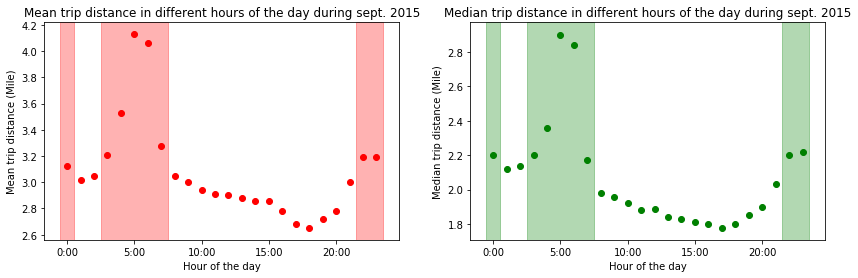

In [5]:
# calculate the mean and median trip distance grouped by hour of the day
# I use the pick_up time for grouping

hour_mean = df.groupby('lpep_pickup_hour', as_index=False)['Trip_distance'].mean().round(2)
hour_median = df.groupby('lpep_pickup_hour', as_index=False)['Trip_distance'].median()

# mean plot
fig, ax = plt.subplots(1,2,figsize = (14,4))
ax[0].scatter(hour_mean['lpep_pickup_hour'], hour_mean['Trip_distance'], c="red")
ax[0].axvspan(-0.5, 0.5, alpha=0.3, color='red')
ax[0].axvspan(2.5, 7.5, alpha=0.3, color='red')
ax[0].axvspan(21.5, 23.5, alpha=0.3, color='red')
ax[0].set_xticklabels(['','0:00','5:00','10:00','15:00','20:00',''])
ax[0].set_xlabel('Hour of the day')
ax[0].set_ylabel('Mean trip distance (Mile)')
ax[0].set_title('Mean trip distance in different hours of the day during sept. 2015')

# median plot
ax[1].scatter(hour_median['lpep_pickup_hour'], hour_median['Trip_distance'], c="green")
ax[1].axvspan(-0.5, 0.5, alpha=0.3, color='green')
ax[1].axvspan(2.5, 7.5, alpha=0.3, color='green')
ax[1].axvspan(21.5, 23.5, alpha=0.3, color='green')
ax[1].set_xticklabels(['','0:00','5:00','10:00','15:00','20:00',''])
ax[1].set_xlabel('Hour of the day')
ax[1].set_ylabel('Median trip distance (Mile)')
ax[1].set_title('Median trip distance in different hours of the day during sept. 2015')

plt.savefig('../figs_reports/trip_distance_hour_ditribution.png',dpi=200)

In [6]:
# trips from/to NYC area airports

# select airport trips using the RateCodeID (code 2 for JFK, code 3 for Neward)
airport_trips = df[(df.RateCodeID == 2) | (df.RateCodeID == 3)]
print("Number of trips to/from NYC airports: ", airport_trips.shape[0])

# average fare of these trips
print("Average time-distance fare (calculated by the meter) of these trips: $", round(airport_trips.Fare_amount.mean(), 2),"per trip.")
print("Average total charged amount (without cash tip) of these trips: $", round(airport_trips.Total_amount.mean(), 2),"per trip.")

Number of trips to/from NYC airports:  5552
Average time-distance fare (calculated by the meter) of these trips: $ 48.98 per trip.
Average total charged amount (without cash tip) of these trips: $ 57.21 per trip.


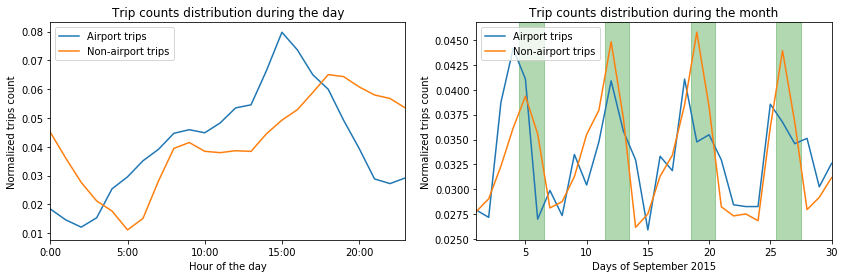

In [7]:
# explore other features of the trips from/to NYC area airports

fig, ax = plt.subplots(1,2,figsize = (14,4))

# airport trip vs. non-airport trip counts during different hours of the day
airport_trips.lpep_pickup_hour.value_counts(normalize=True).sort_index().plot(ax=ax[0])
df.loc[~ df.index.isin(airport_trips.index),'lpep_pickup_hour'].value_counts(normalize=True).sort_index().plot(ax=ax[0])

ax[0].set_xlabel('Hour of the day')
ax[0].set_ylabel('Normalized trips count')
ax[0].set_xticklabels(['0:00','5:00','10:00','15:00','20:00',''])
ax[0].set_title('Trip counts distribution during the day')
ax[0].legend(['Airport trips','Non-airport trips'],loc='best')

# cairport trip vs. non-airport trip counts during different days of the month
# check the pickup day if a weekend
airport_trips.lpep_pickup_day.value_counts(normalize=True).sort_index().plot(ax=ax[1])
df.loc[~ df.index.isin(airport_trips.index),'lpep_pickup_day'].value_counts(normalize=True).sort_index().plot(ax=ax[1])
ax[1].set_xlabel('Days of September 2015')
ax[1].set_ylabel('Normalized trips count')
ax[1].set_title('Trip counts distribution during the month')
ax[1].legend(['Airport trips','Non-airport trips'],loc='best')
ax[1].axvspan(4.5, 6.5, alpha=0.3, color='green')
ax[1].axvspan(11.5, 13.5, alpha=0.3, color='green')
ax[1].axvspan(18.5, 20.5, alpha=0.3, color='green')
ax[1].axvspan(25.5, 27.5, alpha=0.3, color='green')

plt.savefig('../figs_reports/airport_travel_features.png',dpi=200)


**Summary:**

**Mean and median of the day:** 
* Long range trips are in the early morning and around mid-night (as shown by the red and green bands in the figure). The morning peak may be closely related to the morning rush hour commute. Interestingly, the evening peak is lower than the morning peak, and it shows up around mid-night (not evening rush hour). 
* 1) People try to take cabs in the morning to avoid being late to work, and they feel ok to take public transportation after work. 
* 2) The evening peak might be caused by those people who go home from their happy hour, party, or other evening entertainments. And those people are probably living close to where they enjoy their evening life. 

**Trips that originate or terminate at one of the NYC area airports:**
* According to the dictionary of variables, RateCodeID indicates the final rate that was applied. Among those values, JFK (2) and Newark (3), which are the 2 major airports in New York, are included. I used this code to select the trip from/to the airports.
* Number of trips to/from NYC airports:  5552
* Average time-distance fare (calculated by the meter) of these trips: 48.98 USD/trip.
* Average total charged amount (without cash tip) of these trips: 57.21 USD/trip.
**Interesting findings:**
* 1) The hourly distribution shows that the number of airport trips peaks around 15PM, while the non-airport trips peaks ~2 hours later (rush hours). Also, the lowest count of airport rides shows at 2AM about when airports shut down. Other non-airport rides, on the other hand, goes almost completely down at about 5AM.
* 2) The day-by-day distribution during the month shows **a very strong weekly seasonality**. The peaks of both airport and non-airport rides roughly show in Fridays and Saturdays, and the counts of both of the rides drop dramatically in Sundays.
* 3) The count of the airport rides shows its maximum on Sept. 4th (Labor Day long weekend). People like to travel around during the long weekend!

In [8]:
# build a variable for tip as a percentage of the total fare
# cleaning: drop the total fare smaller than $2.5, the initial charge 
# according data downloading website

df = df[(df.Total_amount >= 2.5)]
df['Tip_percentage'] = df.Tip_amount / df.Total_amount * 100
print("Summary of Tip percentage\n",df.Tip_percentage.describe())

Summary of Tip percentage
 count    1.487767e+06
mean     6.665932e+00
std      8.875835e+00
min      0.000000e+00
25%      0.000000e+00
50%      0.000000e+00
75%      1.666667e+01
max      1.000000e+02
Name: Tip_percentage, dtype: float64


In [9]:
# data cleaning

# replace RateCodeID: 99 with np.nan
indices = df[~((df.RateCodeID >= 1) & (df.RateCodeID <= 6))].index
df.loc[indices, 'RateCodeID'] = np.nan    

# replace Extra: 12, 0.25, -0.72 with np.nan
indices = df[~((df.Extra == 0) | (df.Extra == 0.5) | (df.Extra == 1))].index
df.loc[indices, 'Extra'] = np.nan

# check abnormal data
print("Detect abnormal values, and replace them as np.nan:")
print("Total_amount < 0:", df[df.Total_amount < 0].shape[0])
print("Fare_amount < 0:", df[df.Fare_amount < 0].shape[0])
print("Tip_amount < 0:", df[df.Tip_amount < 0].shape[0])
print("Tolls_amount < 0:", df[df.Tolls_amount < 0].shape[0])
print("Store_and_fwd_flag:", df.Store_and_fwd_flag.unique())
print("RateCodeID:", df.RateCodeID.unique()) # should only has values: 1-6
print("Passenger_count:", df.Passenger_count.unique())
print("Extra:", df.Extra.unique()) # should only has values: 0, 0.5, 1
print("MTA_tax:", df.MTA_tax.unique()) # should only has values: 0, 0.5
print("improvement_surcharge:", df.improvement_surcharge.unique()) # should only has values: 0, 0.3
print("Payment_type:", df.Payment_type.unique()) # should only has values: 1-6
print("Trip_type:", df['Trip_type '].unique()) # should only has values: 1, 2


Detect abnormal values, and replace them as np.nan:
Total_amount < 0: 0
Fare_amount < 0: 0
Tip_amount < 0: 0
Tolls_amount < 0: 0
Store_and_fwd_flag: ['N' 'Y']
RateCodeID: [  5.   1.   2.   4.   3.   6.  nan]
Passenger_count: [1 2 5 6 4 3 8 0 9 7]
Extra: [ 0.   0.5  1.   nan]
MTA_tax: [ 0.   0.5]
improvement_surcharge: [ 0.   0.3]
Payment_type: [1 2 3 4 5]
Trip_type: [  2.   1.  nan]


In [53]:
# feature matrix engineering

# Accoding to the document, the Tip_amount doesn't include the cash tips.
# Thus, it is worth checking the records with the Payment_type is cash (Payment_type=2).
# These record highly likely don't include the true tip amounts 
# because the tips are paid in cash.
df_payment2 = df[df['Payment_type'] == 2]
print('# of records have Payment_type=2 and Tip_percentage != 0:',
      df_payment2[df_payment2['Tip_percentage'] != 0].shape[0]) 
print('# of records have Payment_type=2 and Tip_percentage == 0:',
      df_payment2[df_payment2['Tip_percentage'] == 0].shape[0]) 

# for my predictive model, I will not consider these payment_type=2 records
df_cleaned = df[df['Payment_type'] != 2]

# transfer Storage, MTA_tax, trip_type with boolean variable
store_flag = df_cleaned['Store_and_fwd_flag'].isin(['Y'])
MTA_flag = df_cleaned.MTA_tax.apply(lambda x: x == 0.5)
trip_type_flag = df_cleaned['Trip_type '].apply(lambda x: x == 1)

# calculate trip_duration (in sec) 
trip_duration = np.empty([len(df_cleaned), 1])

for i in range(len(df_cleaned)):
    if df_cleaned.iloc[i]['lpep_pickup_day'] == df_cleaned.iloc[i]['lpep_dropoff_day']:
        trip_duration[i] = (df_cleaned.iloc[i]['lpep_dropoff_hour']*3600 
                            + df_cleaned.iloc[i]['lpep_dropoff_min']*60 
                            + df_cleaned.iloc[i]['lpep_dropoff_sec'] 
                            - df_cleaned.iloc[i]['lpep_pickup_hour']*3600 
                            - df_cleaned.iloc[i]['lpep_pickup_min']*60 
                            - df_cleaned.iloc[i]['lpep_pickup_sec'])
    else:
        trip_duration[i] = (24*3600 
                            - df_cleaned.iloc[i]['lpep_dropoff_hour']*3600 
                            - df_cleaned.iloc[i]['lpep_dropoff_min']*60 
                            - df_cleaned.iloc[i]['lpep_dropoff_sec'] 
                            + df_cleaned.iloc[i]['lpep_pickup_hour']*3600
                            + df_cleaned.iloc[i]['lpep_pickup_min']*60 
                            + df_cleaned.iloc[i]['lpep_pickup_sec'])

df_cleaned['trip_duration'] = trip_duration/3600

# combine all the features
# Total_amount featrue is a linear combination of Fare_amount, Extra, MTA_tax, surcharge, Tolls_amount

cols = ['Tip_percentage','Passenger_count','Total_amount', 'trip_duration',
        'lpep_dropoff_hour','weekend_holiday_flag']
features = df_cleaned[cols]

print(features.info())

<class 'pandas.core.frame.DataFrame'>
Int64Index: 708376 entries, 0 to 1494925
Data columns (total 6 columns):
Tip_percentage          708376 non-null float64
Passenger_count         708376 non-null int64
Total_amount            708376 non-null float64
trip_duration           708376 non-null float64
lpep_dropoff_hour       708376 non-null int64
weekend_holiday_flag    708376 non-null bool
dtypes: bool(1), float64(3), int64(2)
memory usage: 53.1 MB
None


In [54]:
# define functions that help to train models and perform cv

# optimize n_estimator through grid search
def optimize_num_trees(sk_model, param_test, scoring_method, train, variables, target):
    """"
    sk_model: the sk-learn model to use
    param_test: the list of parameters needs to be tested
    scoring_method: the metric used for evaluate, str
    train: the training dataset, dataframe
    variables: dataframe column names, list
    target: dataframe column name, list
    """
    print('start optimizing # of trees...')
    gsearch = GridSearchCV(estimator=sk_model, param_grid = param_test, 
                           scoring=scoring_method,n_jobs=2,iid=False, cv=3)
    gsearch.fit(train[variables],train[target])
    print('optimizing # of trees ends...')
    return gsearch

def model_fit(sk_model, train, test, variables, target, CV=True, CV_folds=3):
    """"
    sk_model: the sk-learn model to use
    train: the training dataset, dataframe
    test: the test datset for CV, dataframe
    variables: dataframe column names, list
    target: dataframe column name, list
    CV: if do cross validation, boolean
    CV_folds: the # of dimensions for CV, int
    """
    print('start random forest model...')
    sk_model.fit(train[variables],train[target])
    # predict on train set:
    train_predictions = sk_model.predict(train[variables])
    #perform cross-validation
    if CV:
        cv_score = cross_validation.cross_val_score(sk_model, test[variables], test[target],
                                                    cv=CV_folds,scoring='neg_mean_squared_error')
        
    #print feature importance
    feature_imp = pd.Series(sk_model.feature_importances_, variables).sort_values(ascending=False)
    feature_imp.plot(kind='bar',title='Feature Importance')
    plt.ylabel('Score')
    plt.show()
    print('model finishes...')

the size of train set is  (425025, 6)
the size of test set is  (141675, 6)
the size of holdout set is  (141676, 6)
start optimizing # of trees...
optimizing # of trees ends...
{'n_estimators': 200} -31.738724615400866
start random forest model...


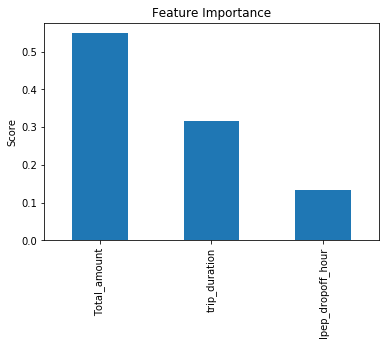

model finishes...
Holdout dataset mean squared error: 30.4750425535
Holdout dataset r2: 0.50529193733


In [55]:
# sperate the train, test, and holdout sets
# 60% train, 20% test, 20% holdout
train = features.loc[np.random.choice(features.index,size=int(len(features)*0.6),replace=False)]
inx = features.index[~ features.index.isin(train.index)]
test = features.loc[np.random.choice(inx,size=int(len(features)*0.2),replace=False)]
inx = features.index[~(features.index.isin(train.index) | features.index.isin(test.index))]
holdout = features.loc[inx]

print('the size of train set is ', np.shape(train))
print('the size of test set is ', np.shape(test))
print('the size of holdout set is ', np.shape(holdout))

target = 'Tip_percentage'

# variables = ['Total_amount', Passenger_count','lpep_dropoff_hour',
#              'weekend_holiday_flag','MTA_flag','trip_duration'] 
# remove features with low importance
variables = ['Total_amount', 'trip_duration', 'lpep_dropoff_hour']

# Random Forest

# choose the best # of trees
param = {'n_estimators':[50,100,150,200]} 

rfr = RandomForestRegressor()

gs_rfr = optimize_num_trees(rfr, param,'neg_mean_squared_error', train, variables, target)
print(gs_rfr.best_params_, gs_rfr.best_score_)
model_fit(gs_rfr.best_estimator_, train, test, variables,target,'mean_squared_error')

# save the best params
with open('my_rfr_reg2.pkl','wb') as fid:
    pickle.dump(gs_rfr.best_estimator_,fid)
    fid.close()

target_pred = gs_rfr.best_estimator_.predict(holdout[variables])

print('Holdout dataset mean squared error:',
      mean_squared_error(holdout.Tip_percentage, target_pred))
print('Holdout dataset r2:', r2_score(holdout.Tip_percentage, target_pred))

# Summary:

* This model is to predict the tip_percentage of each individual trip. 
* **Accoding to the data dictionary, the Tip_amount doesn't include the cash tips.** After checking the dataset, only two records with the Payment_type is cash (Payment_type=2) have a tip value > 0. That means over 99.9% of people who pay in cash for the ride might also pay tips in cash, which won't be shown in this dataset.
* **All records that have a cash payment_type are excluded from the training and test dataset. These record don't include the true tip amounts.**
* The total number of records that with Payment_type != cash is **708,376**.

* **Model building steps:** 

* **(1) Data obersvation and cleaning:** 
    Check and drop abnormal values (according to the data dictionary) in the columns, no imputation was done. 
* **(2) Feature engineering:** 
    Create features: 'Tip_percentage', 'Total_amount', 'MTA_flag', 'lpep_dropoff_hour', 'weekend_holiday_flag', 'trip_type_flag'. Not all the features were used in the final model after feature selection.
* **(3) Model selection and parameter optimization:**
    Random Forest Regressor is selected for the model. The number of trees was optimized using 3-fold cross-validation. The mean square error was used as a valuation metric. First  trail run of the model with all features gave feature importance of each feature. Couple features with very low feature importance were removed from the inputs in the final model.
* **(4) final prediction:** 
    The total of 708,376 records were randomly sperated: 60% in training set, 20% of test set (for cross-validation), and 20% of holdout set (for test the final model). 
    **Three features in the final model: 'Total_amount', 'lpep_dropoff_hour', 'trip_duration'.** 
    r^2 for the test set is about 0.5.


# Visualization: NY Green cab traffic flow

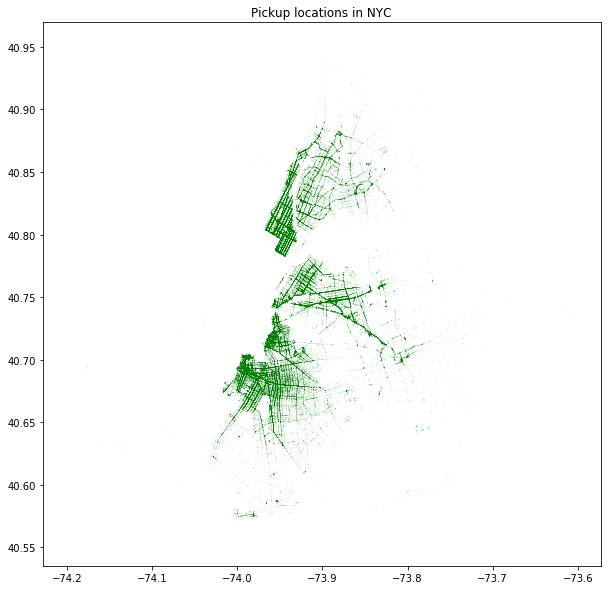

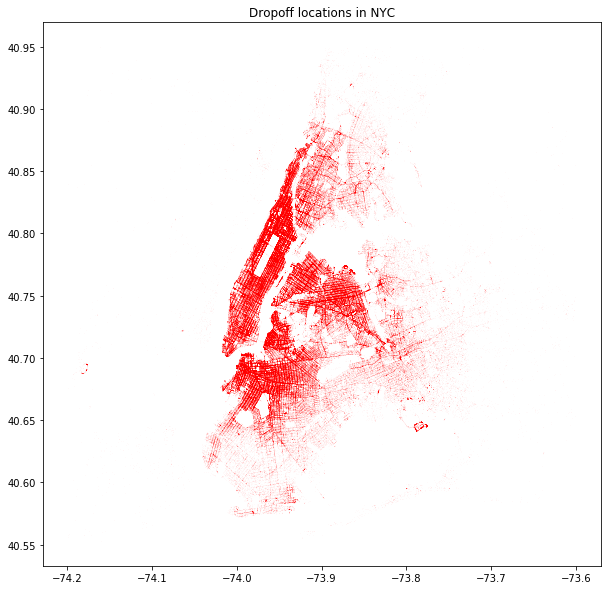

In [55]:
# plot the pickup and dropoff locations

xlim = [-74.2, -73.6]
ylim = [40.55, 40.95] # remove the very long trips from the map
df_plot = df[(df.Pickup_longitude > xlim[0]) & (df.Pickup_longitude < xlim[1])]
df_plot = df_plot[(df_plot.Dropoff_longitude > xlim[0]) & (df_plot.Dropoff_longitude < xlim[1])]
df_plot = df_plot[(df_plot.Pickup_latitude > ylim[0]) & (df_plot.Pickup_latitude < ylim[1])]
df_plot = df_plot[(df_plot.Dropoff_latitude > ylim[0]) & (df_plot.Dropoff_latitude < ylim[1])]

plt.figure(figsize = (10,10))
plt.plot(df_plot.Pickup_longitude,df_plot.Pickup_latitude,'.', alpha = 0.4, 
         markersize = 0.03, color='green')
plt.title('Pickup locations in NYC')
plt.savefig('../figs_reports/Pickup_map.png',dpi=200)

plt.figure(figsize = (10,10))
plt.plot(df_plot.Dropoff_longitude,df_plot.Dropoff_latitude,'.', alpha = 0.4, 
         markersize = 0.03, color='red')
plt.title('Dropoff locations in NYC')
plt.savefig('../figs_reports/Dropoff_map.png',dpi=200)

# Feature 1:
Very obvious interesting feature can be observed: Almost no people were picked up in mid- and low- Manhattan. Is it due to some sort of green cab ban in these areas? The dropoff locations spread much more out.

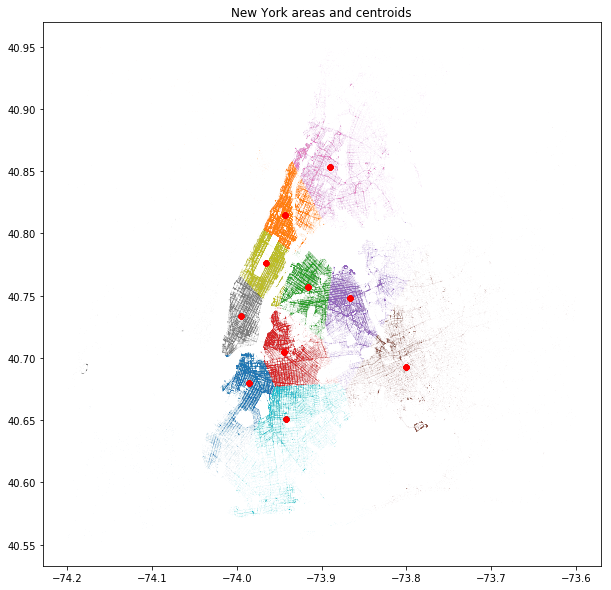

In [85]:
# divide NYC into clusters use drop off locations

kmeans = KMeans(n_clusters=10, random_state=2, n_init = 10).fit(df_plot[['Dropoff_longitude','Dropoff_latitude']])
df_plot['cluster_label'] = kmeans.labels_
clusters = pd.DataFrame()
clusters['x'] = kmeans.cluster_centers_[:,0]
clusters['y'] = kmeans.cluster_centers_[:,1]
clusters['label'] = range(len(clusters))

plt.figure(figsize = (10,10))
for label in df_plot.cluster_label.unique():
    plt.plot(df_plot.Dropoff_longitude[df_plot.cluster_label == label],
             df_plot.Dropoff_latitude[df_plot.cluster_label == label],
             '.', alpha = 0.3, markersize = 0.03)
    plt.plot(clusters.x, clusters.y, 'o', color = 'r', markersize = 5)
plt.title('New York areas and centroids')
plt.savefig('../figs_reports/New York areas.png',dpi=200)

# Feature 2:
I divided the NYC into 10 clusters. The centroids roughly represent different NYC neighborhoods. Upper-, Mid-, Downtown- Manhattan, Bronx, Queens and Brooklyn, etc.

/anaconda3/lib/python3.6/site-packages/matplotlib/pyplot.py:523: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)


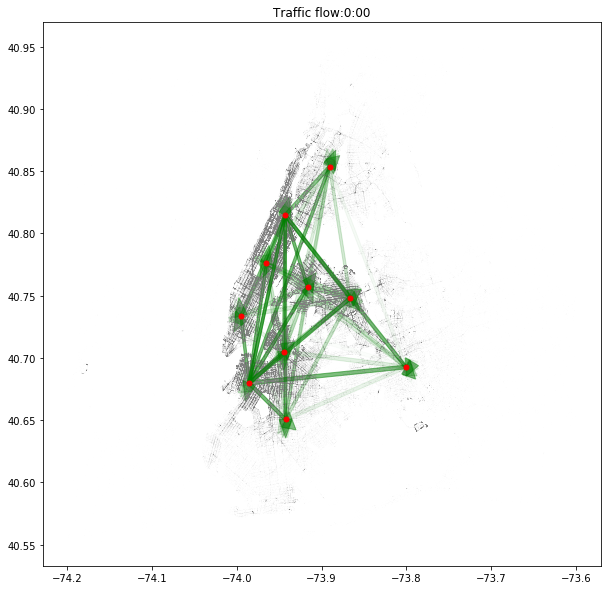

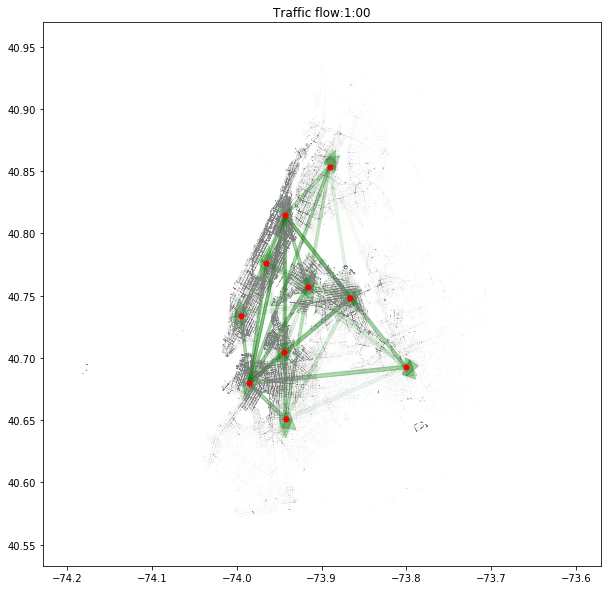

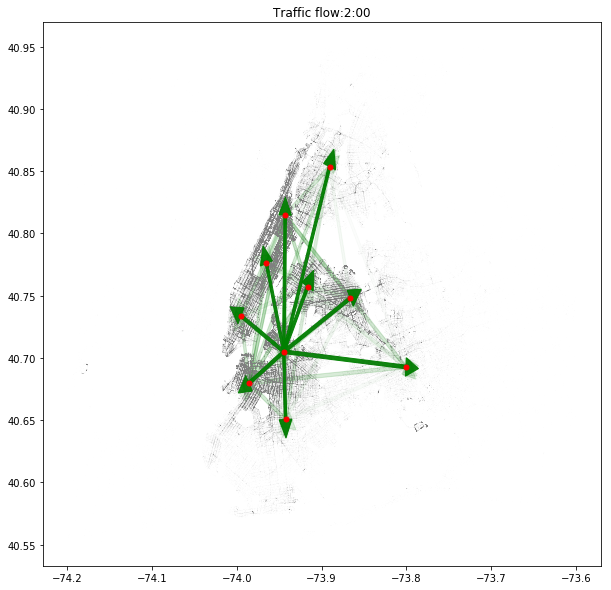

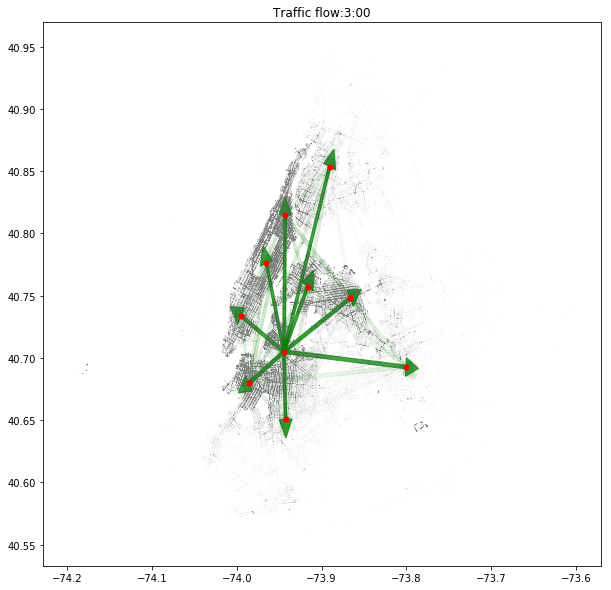

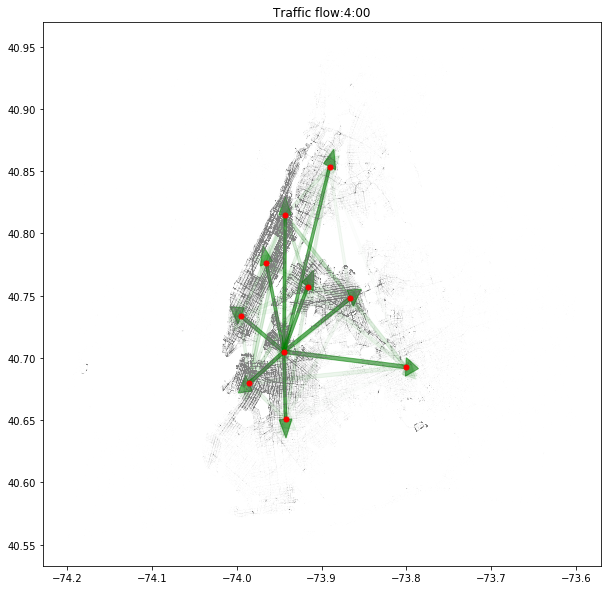

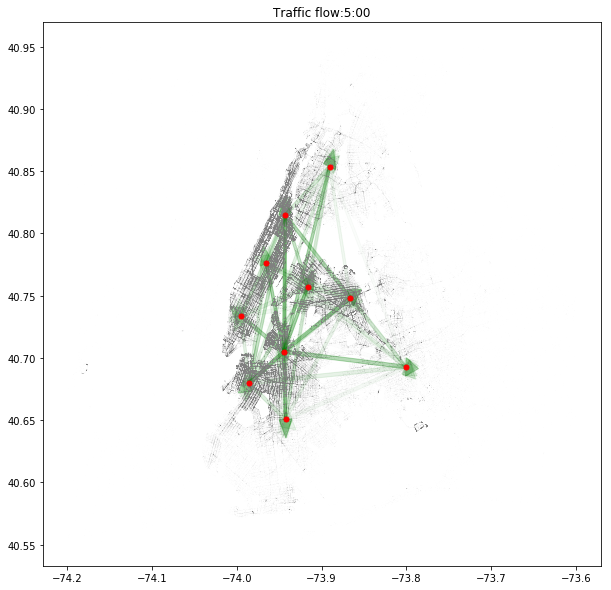

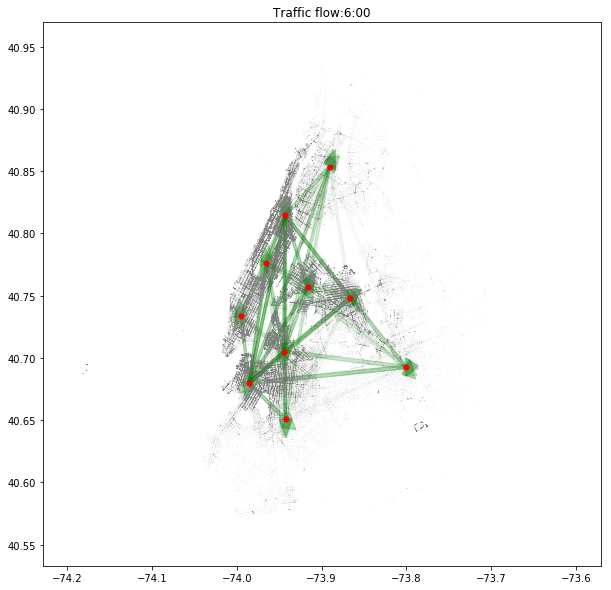

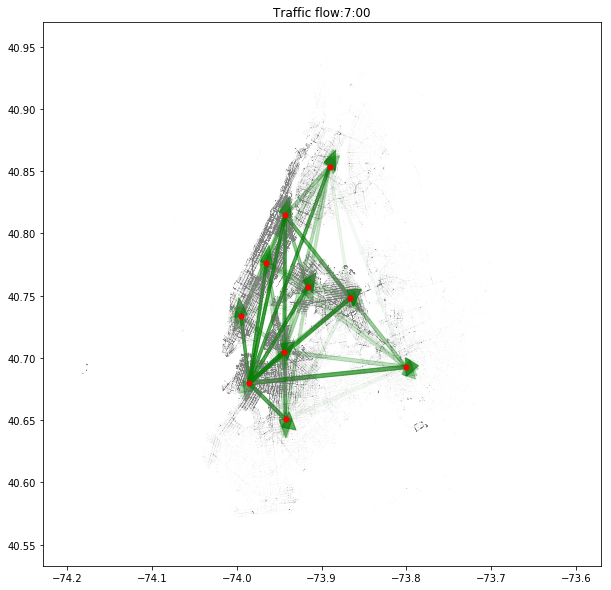

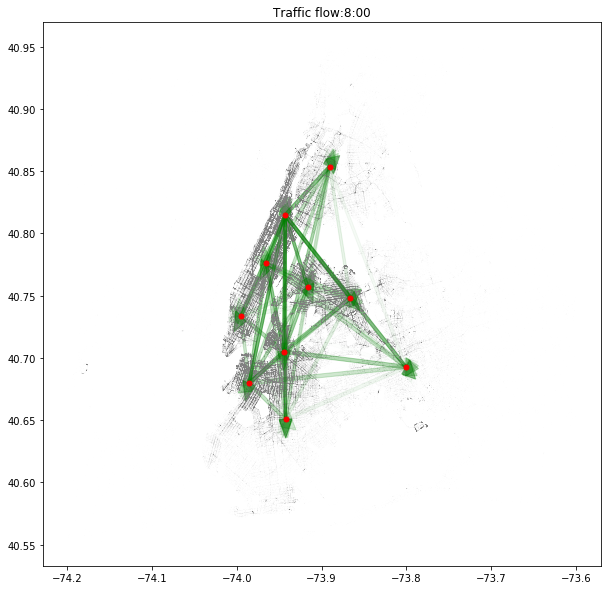

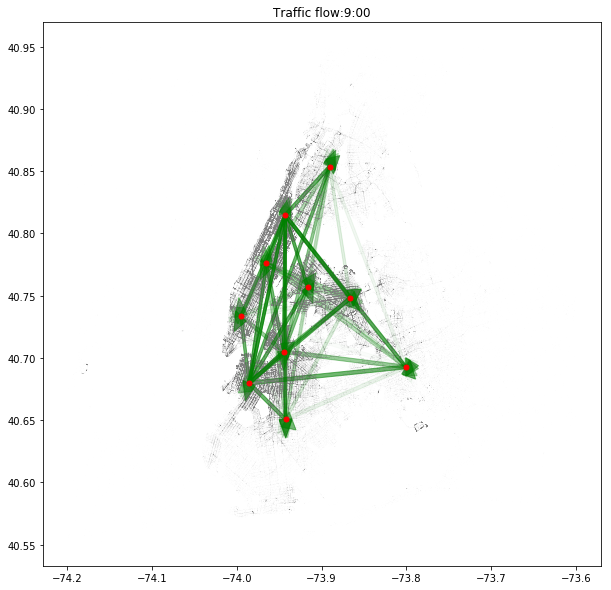

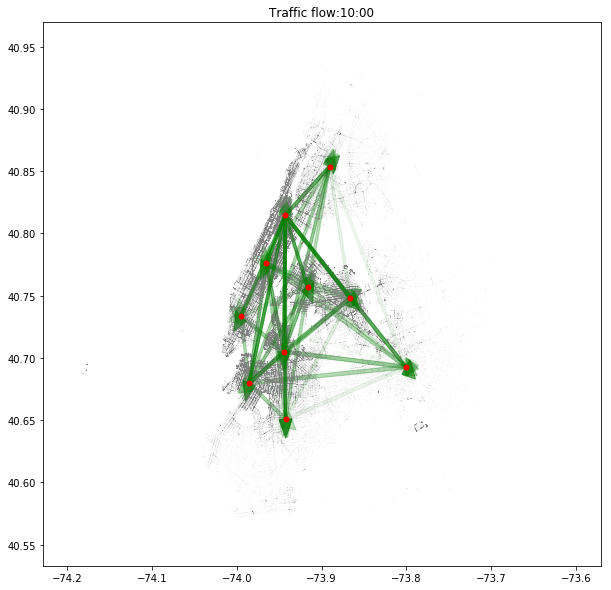

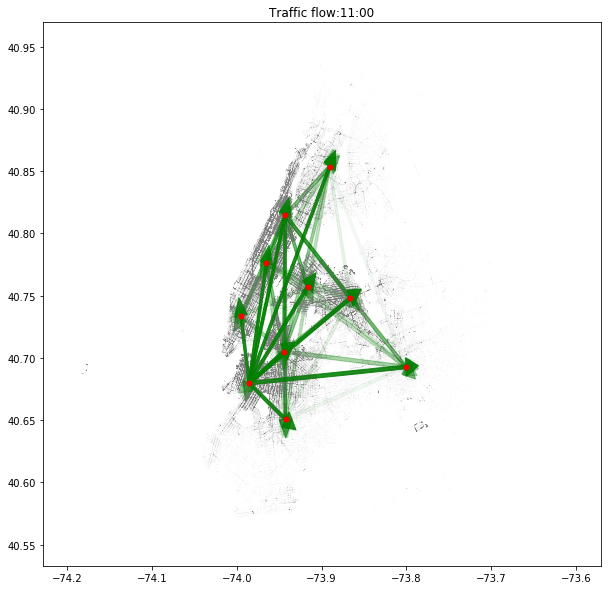

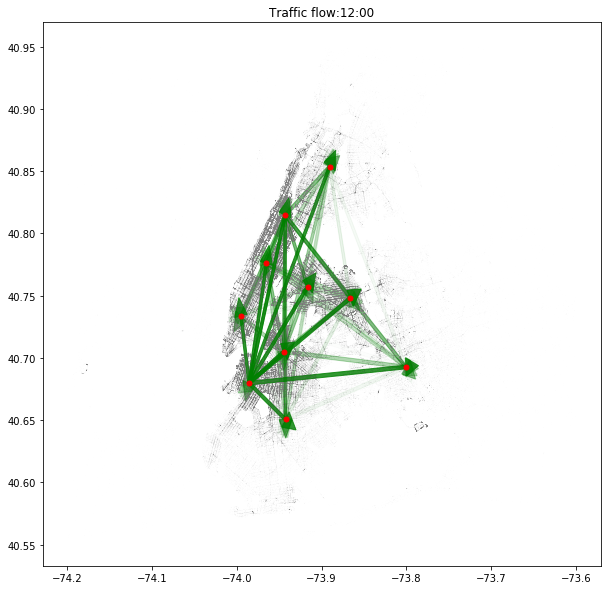

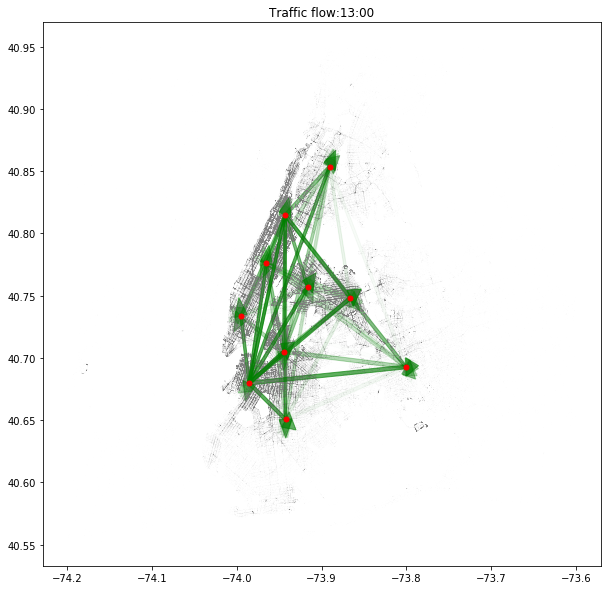

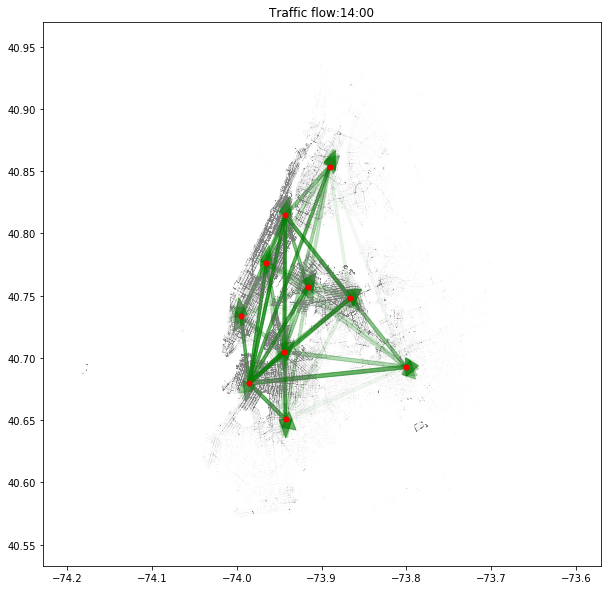

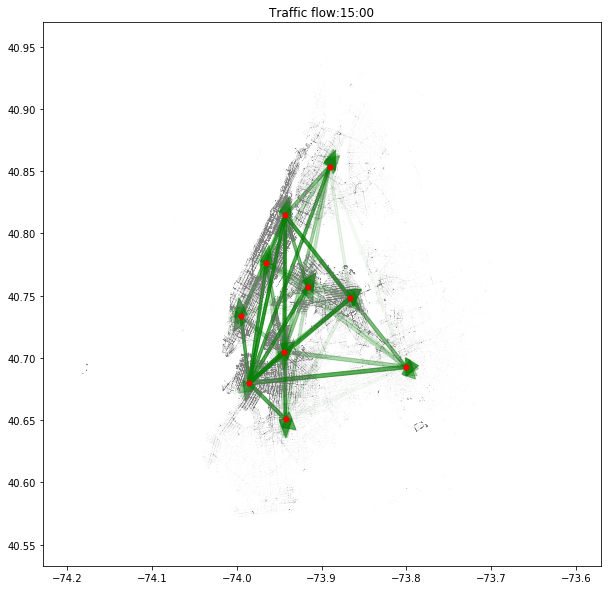

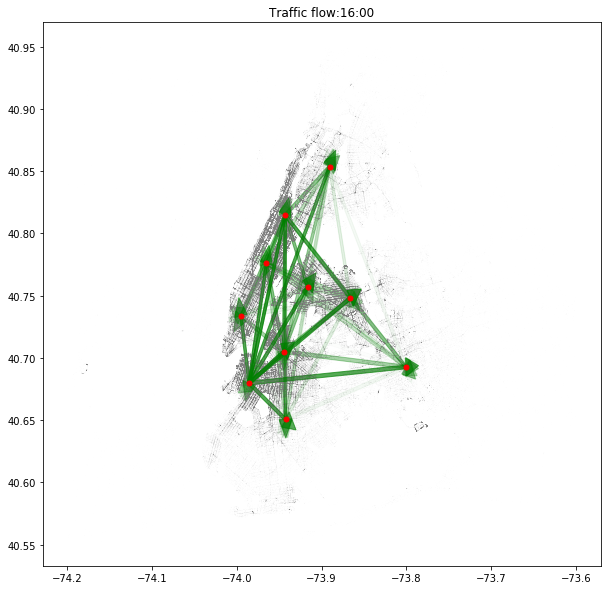

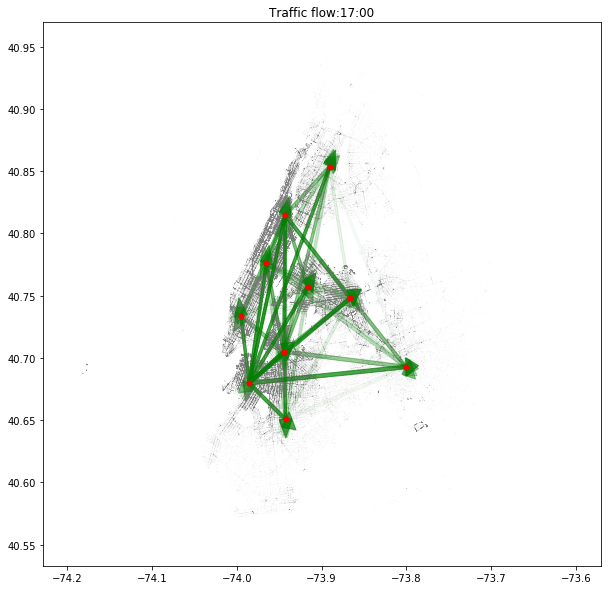

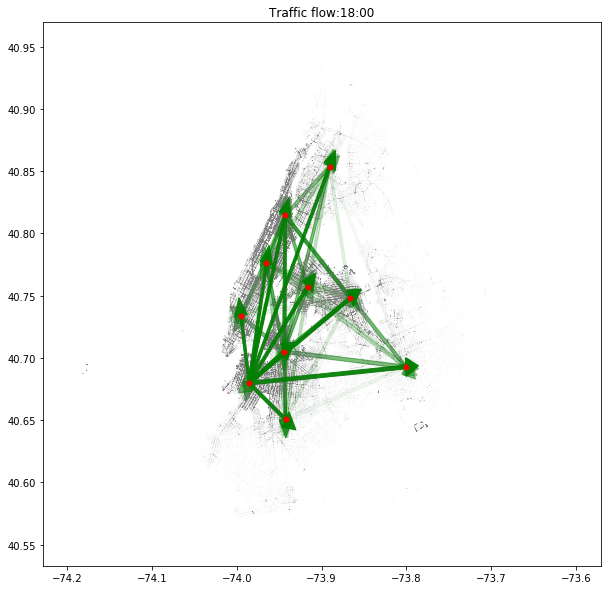

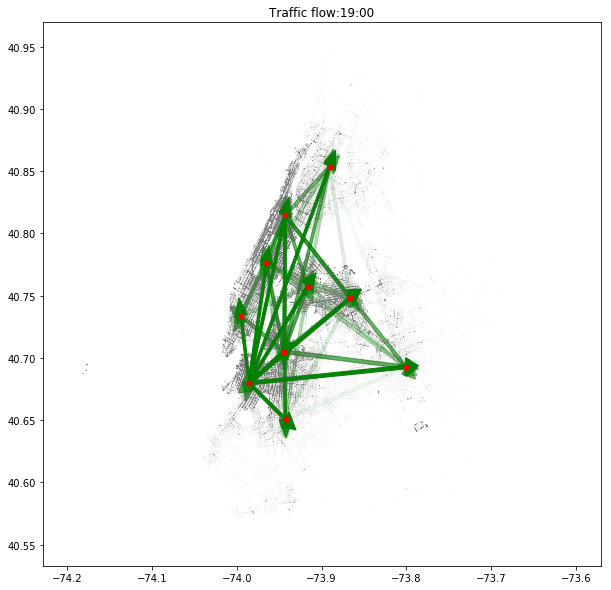

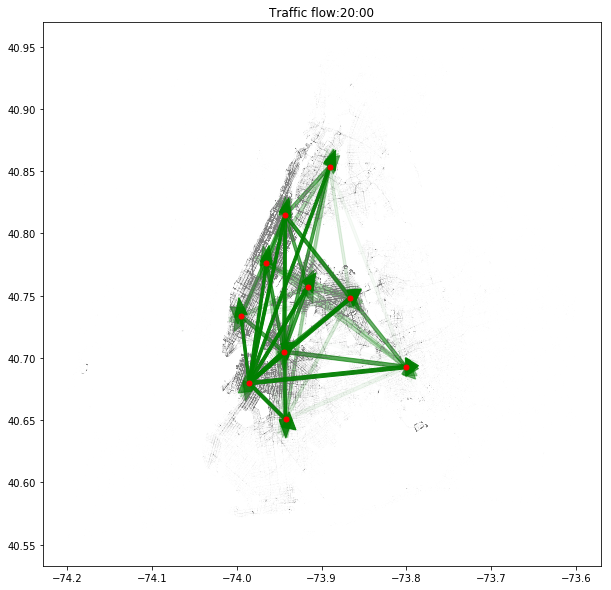

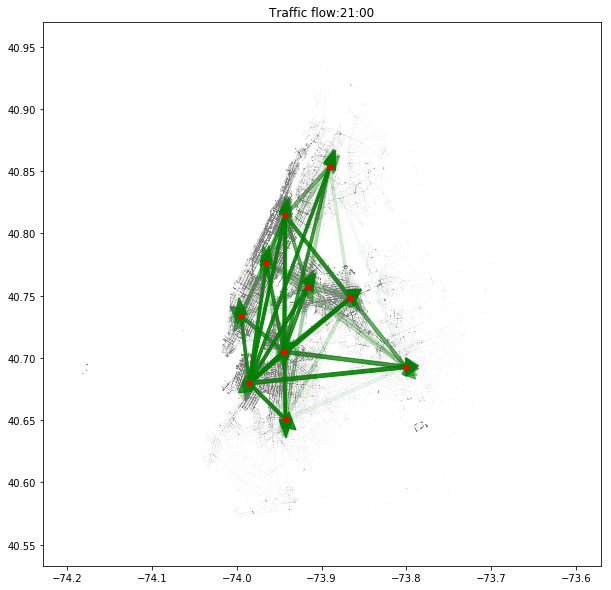

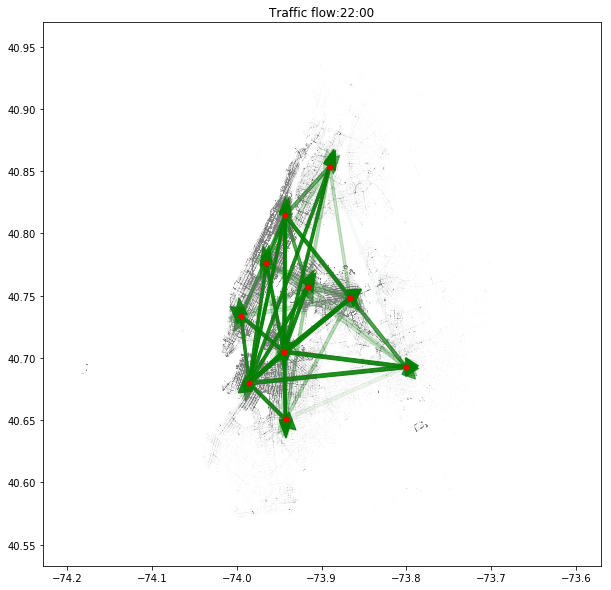

In [178]:
# compare the traffic flow in different hours during a day

# predict the pickup and dropoff clusters for each record
df_plot['pickup_c'] = kmeans.predict(df_plot[['Pickup_longitude','Pickup_latitude']])
df_plot['dropoff_c'] = kmeans.predict(df_plot[['Dropoff_longitude','Dropoff_latitude']])

# generate plots for each hour

def traffic_flow(hour):
    plt.figure(figsize = (10,10))
    plt.title('Traffic flow:' + str(int(hour)) + ':00')
    plt.plot(df_plot.Dropoff_longitude,df_plot.Dropoff_latitude,'.', alpha = 0.2, 
             markersize = 0.01, color='grey')
    plt.plot(clusters.x, clusters.y, 'o', color = 'r', markersize = 5)

    for label in range(len(clusters)):
        for label2 in range(len(clusters)):
            if label != label2:
                num_rides = len(df_plot[(df_plot.pickup_c == label) & 
                                        (df_plot.dropoff_c == dest_label) & 
                                        (df_plot.lpep_dropoff_hour == hour)])
                dist_x = clusters.loc[label]['x'] - clusters.loc[label2]['x']
                dist_y = clusters.loc[label]['y'] - clusters.loc[label2]['y']
                pct = np.true_divide(num_rides,len(df_plot))
                plt.arrow(clusters.loc[label]['x'], clusters.loc[label]['y'], -dist_x, -dist_y, 
                          color= 'green', alpha=600*pct, 
                          width=0.003, head_width=0.015, head_length=0.015)

# generate plots for each hour
for hour in range(0,23):
    traffic_flow(hour)

# Feature 3:
The traffic flow figures in different hours clearly shows some trends of the green taxi in NYC:
* The darkness of the green arrow shows the traffic intensity from one cluster to another. The figures shows that, from around 2am to 4am, most of the green cab rides started from north Brooklyn. 
* The morning traffic starts around 7am.
* The peak in the afternoon starts to show up around 18:00.
